In [28]:
import pandas as pd
import konlpy
import gensim

In [77]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터 전처리

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [78]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    #중복 제거 & 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    # 토큰화하기 & 불용어 제거
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # dictionary with index
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    #convert word into index function
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [79]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 모델 구성을 위한 데이터 분석 및 가공
* 데이터 셋 문장 길이 분포
* 적절한 최대 문장 길이 지정
* 패딩 추가

In [32]:
len(X_train)

146182

In [69]:
lengths = [len(sentence) for sentence in X_train]

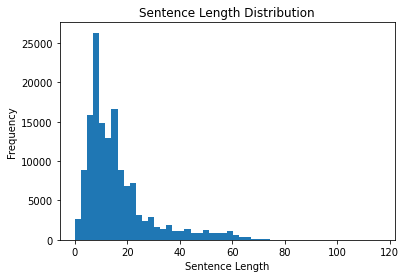

In [70]:
import matplotlib.pyplot as plt
# 문장 길이 분포 확인
plt.hist(lengths, bins=50)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution')
plt.show()

In [80]:
percentiles = [50, 75, 90, 95, 99]
for percentile in percentiles:
    print(f'{percentile} 퍼센타일: {int(np.percentile(lengths, percentile))} 글자')

# 상위 95% 문장을 포함할 수 있는 최대 길이
maxlen = int(np.percentile(lengths, 95))
print(f'적절한 문장 최대 길이(maxlen): {maxlen}')

50 퍼센타일: 12 글자
75 퍼센타일: 19 글자
90 퍼센타일: 33 글자
95 퍼센타일: 47 글자
99 퍼센타일: 61 글자
적절한 문장 최대 길이(maxlen): 47


In [81]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_len = int(max_tokens)
print('pad_sequences maxlen : ', max_len)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [82]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

In [83]:
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
# embedding
vocab_size = len(word_to_index)
word_vector_dim = 4 # Suppose that embedding vector's dimension : 4

embedding = Embedding(input_dim = vocab_size, output_dim = word_vector_dim, mask_zero = True)

X_train = np.array(X_train, dtype = 'object')
X_train = pad_sequences(raw_inputs, value = word_to_index['<PAD>'], padding='pre', maxlen=maxlen)
output_tr = embedding(X_train)

X_test = np.array(X_test, dtype = 'object')
X_test = pad_sequences(X_test, value = word_to_index['<PAD>'], padding='pre', maxlen=maxlen)
output_te = embedding(X_test)

### 모델 구성 및 validation set 구성

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [85]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

### tf-idf를 사용한 로지스틱 회귀 사용

In [86]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectoriztion()
X_train_tfidf = vectorizer

NameError: name 'TextVectoriztion' is not defined

### LSTM 모델 사용

In [92]:
def lstm_model(vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_shape = (None,)))
    model.add(LSTM(128)) #벡터의 차원수 변경 가능
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

#### 모델 훈련 개시

#### Epoch: 15

In [93]:
model = lstm_model(vocab_size, word_vector_dim, maxlen)
history = model.fit(np.array(X_train), np.array(y_train), validation_data = (np.array(X_val), np.array(y_val)), epochs = 15, batch_size = 64 )

Epoch 1/15
1828/1828 [==============================] - 12s 6ms/step - loss: 0.4089 - accuracy: 0.8121 - val_loss: 0.3553 - val_accuracy: 0.8461
Epoch 2/15
1828/1828 [==============================] - 11s 6ms/step - loss: 0.3356 - accuracy: 0.8574 - val_loss: 0.3509 - val_accuracy: 0.8476
Epoch 3/15
1828/1828 [==============================] - 11s 6ms/step - loss: 0.3180 - accuracy: 0.8662 - val_loss: 0.3462 - val_accuracy: 0.8507
Epoch 4/15
1828/1828 [==============================] - 11s 6ms/step - loss: 0.3020 - accuracy: 0.8737 - val_loss: 0.3466 - val_accuracy: 0.8534
Epoch 5/15
1828/1828 [==============================] - 11s 6ms/step - loss: 0.2867 - accuracy: 0.8810 - val_loss: 0.3366 - val_accuracy: 0.8554
Epoch 6/15
1828/1828 [==============================] - 10s 6ms/step - loss: 0.2712 - accuracy: 0.8882 - val_loss: 0.3598 - val_accuracy: 0.8551
Epoch 7/15
1828/1828 [==============================] - 10s 6ms/step - loss: 0.2554 - accuracy: 0.8958 - val_loss: 0.3375 - val_ac

In [94]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

#### Loss, Accuracy 그래프 시각화

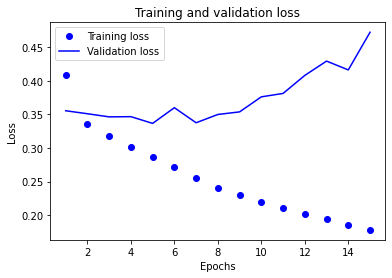

In [95]:
epochs = range(1, len(acc) +1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

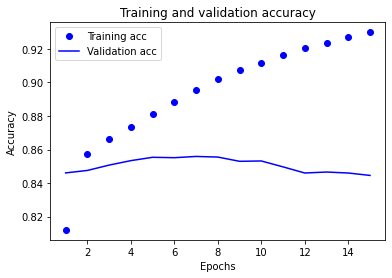

In [96]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Epoch: 20

In [87]:
def lstm_model(vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_shape = (None,)))
    model.add(LSTM(128)) #벡터의 차원수 변경 가능
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

#### 모델 훈련 개시

In [88]:
model = lstm_model(vocab_size, word_vector_dim, maxlen)
history = model.fit(np.array(X_train), np.array(y_train), validation_data = (np.array(X_val), np.array(y_val)), epochs = 20, batch_size = 64 )

Epoch 1/20
1828/1828 [==============================] - 18s 6ms/step - loss: 0.4074 - accuracy: 0.8148 - val_loss: 0.3622 - val_accuracy: 0.8428
Epoch 2/20
1828/1828 [==============================] - 11s 6ms/step - loss: 0.3361 - accuracy: 0.8574 - val_loss: 0.3509 - val_accuracy: 0.8478
Epoch 3/20
1828/1828 [==============================] - 11s 6ms/step - loss: 0.3160 - accuracy: 0.8668 - val_loss: 0.3417 - val_accuracy: 0.8521
Epoch 4/20
1828/1828 [==============================] - 11s 6ms/step - loss: 0.2998 - accuracy: 0.8751 - val_loss: 0.3394 - val_accuracy: 0.8537
Epoch 5/20
1828/1828 [==============================] - 10s 6ms/step - loss: 0.2847 - accuracy: 0.8811 - val_loss: 0.3452 - val_accuracy: 0.8546
Epoch 6/20
1828/1828 [==============================] - 10s 6ms/step - loss: 0.2688 - accuracy: 0.8892 - val_loss: 0.3633 - val_accuracy: 0.8537
Epoch 7/20
1828/1828 [==============================] - 11s 6ms/step - loss: 0.2536 - accuracy: 0.8960 - val_loss: 0.3529 - val_ac

In [89]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

#### Loss, Accuracy 그래프 시각화

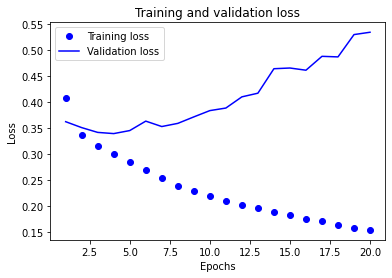

In [90]:
epochs = range(1, len(acc) +1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

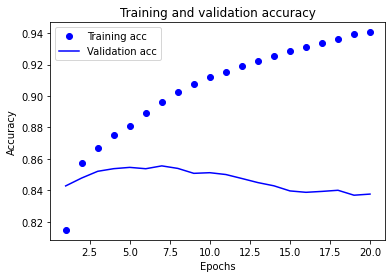

In [91]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### CNN 모델 사용

#### BERT 모델 사용

### 학습된 Embedding 레이어 분석

### 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

아쉬운 점: 많은 모델을 실험해보지 못해 매우 아쉬움. 또한 데이터 전처리도 대충하고 넘어가서 아쉽다.
배운 점: max length를 다양하게 잡을 수 있다는 것. LSTM에서 유닛수를 다르게 하면 다양한 결과가 나온다는 점이 인상적이다.
